In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import datetime
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pathlib import Path
import xarray as xr
# local module
import mypaths
from common_defs import FLIGHTS, MASIN_FILE_MASK
import sat_tools

In [3]:
flight_date = datetime(2018, 3, 9, 11)
flight_id = [k for k, v in FLIGHTS.items() if v==f'{flight_date:%Y%m%d}'][0]

In [4]:
sat_opt = dict(instrument='avhrr', platform='metopb', channel='band2_vis')

In [5]:
# %debug
url = sat_tools.get_nearest_url(flight_date, **sat_opt)

In [6]:
sat_image_name = mypaths.sat_dir / f'{flight_date:%Y%m%d}' / Path(url).name
if not sat_image_name.is_file():
    stat = sat_tools.download_file(url=url, save_dir=mypaths.sat_dir/f'{flight_date:%Y%m%d}')
    assert stat == 0

In [7]:
im, extent, crs = sat_tools.read_raster_stereographic(str(sat_image_name))

In [8]:
projection = ccrs.Stereographic(central_latitude=68.5, central_longitude=-21)
# xticks = list(np.arange(-180, 180, 5))
# yticks = list(np.arange(0, 90, 1))
mapkw = dict(transform=ccrs.PlateCarree())

In [9]:
stride = 10

In [10]:
# df = pd.read_excel('/local/fwv14jru/Desktop/VP-FAZ 08.03.18.xlsx')

# x = df.Longitude.values
# y = df.Latitude.values
# z = df['Altitude (m)'].values

In [11]:
masin_data_path = mypaths.masin_dir / f'flight{flight_id}' / MASIN_FILE_MASK.format(flight_date=flight_date,
                                                                                    flight_id=flight_id)

In [12]:
ds = xr.open_dataset(masin_data_path, decode_times=False)

In [13]:
x = ds.LON_OXTS[~ds.ALT_OXTS.isnull()].values#[8000:]
y = ds.LAT_OXTS[~ds.ALT_OXTS.isnull()].values#[8000:]
z = ds.ALT_OXTS[~ds.ALT_OXTS.isnull()].values#[8000:]

In [14]:
cmap = plt.cm.viridis

In [15]:
# %matplotlib ipympl

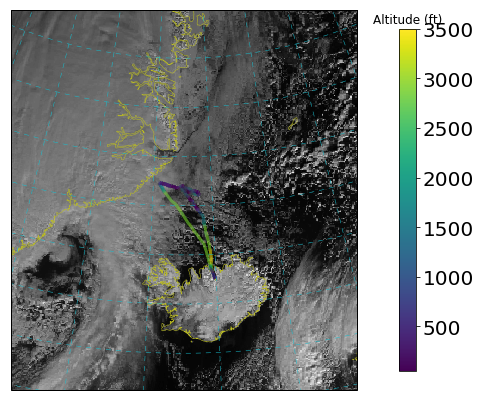

In [16]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection=projection)
ax.set_extent([-34, -7.8, 61, 75.2])
ax.coastlines(resolution='10m', color='C8', linewidth=0.5)
gl = ax.gridlines(linestyle=(0, (10, 10)), linewidth=0.5, color='C9')
h = ax.imshow(im[::stride, ::stride], origin='upper', extent=extent, transform=crs, cmap='gray', interpolation='nearest')

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap, linewidth=3,
                    norm=plt.Normalize(np.nanmin(z), np.nanmax(z)), **mapkw)
lc.set_array(z)
h = ax.add_collection(lc)
cb = fig.colorbar(h, ax=ax, shrink=0.9)
cb.ax.tick_params(labelsize=20)
cb.ax.set_title('Altitude (ft)');

# ax2.view_init(90)

In [17]:
fig.savefig(mypaths.plotdir / f'flight_{flight_id}_{"_".join(sat_opt.values())}.png', dpi=100, bbox_inches='tight')